In [ ]:
import pandas as pd

# Cargar dataset original
df = pd.read_csv("/content/dataset_sdn.csv")

# --- 1. Renombrar columna objetivo ---
# Ajustá esto si tu columna tiene otro nombre (por ej. "label" o "target")
if 'label' in df.columns:
    df = df.rename(columns={'label': 'es_ataque_dos'})

# --- 2. Convertir etiqueta a 0 y 1 ---
# Si tus etiquetas son texto, ej: "DoS" / "Normal"
df['es_ataque_dos'] = df['es_ataque_dos'].replace({
    'DoS': 1,
    'Normal': 0,
    'dos': 1,
    'normal': 0
})

# --- 3. Quitar columnas no numéricas ---
for col in df.columns:
    if df[col].dtype == 'object' and col != 'es_ataque_dos':
        df = df.drop(columns=[col])

# --- 4. Eliminar filas con valores vacíos ---
df = df.dropna()

# --- 5. Asegurar tipo entero en la etiqueta ---
df['es_ataque_dos'] = df['es_ataque_dos'].astype(int)

# --- 6. Guardar nuevo dataset limpio ---
df.to_csv("dos_full.csv", index=False)
print("✅ Dataset limpio guardado como 'dos_full.csv'")
print(df.head())

✅ Dataset limpio guardado como 'dos_full.csv'
      dt  switch  pktcount  bytecount  dur   dur_nsec       tot_dur  flows  \
0  11425       1     45304   48294064  100  716000000  1.010000e+11      3   
1  11605       1    126395  134737070  280  734000000  2.810000e+11      2   
2  11425       1     90333   96294978  200  744000000  2.010000e+11      3   
3  11425       1     90333   96294978  200  744000000  2.010000e+11      3   
4  11425       1     90333   96294978  200  744000000  2.010000e+11      3   

   packetins  pktperflow  byteperflow  pktrate  Pairflow  port_no   tx_bytes  \
0       1943       13535     14428310      451         0        3  143928631   
1       1943       13531     14424046      451         0        4       3842   
2       1943       13534     14427244      451         0        1       3795   
3       1943       13534     14427244      451         0        2       3688   
4       1943       13534     14427244      451         0        3       3413   

   r

In [ ]:
# ============================================================
# BÚSQUEDA PROGRESIVA + EARLY STOPPING SOBRE HIPERPARÁMETROS
# (asumiendo que ya corriste la celda que genera df y dos_full.csv)
# ============================================================
import numpy as np
import pandas as pd
from itertools import product

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             average_precision_score, classification_report, confusion_matrix)

# ------------------------------------------------------------
# 1) Cargar el CSV limpio (o usar df existente)
# ------------------------------------------------------------
try:
    _ = df  # si existe en memoria, seguimos
except NameError:
    df = pd.read_csv("dos_full.csv")

assert "es_ataque_dos" in df.columns, "Falta la columna 'es_ataque_dos'"

X = df.drop(columns=["es_ataque_dos"])
y = df["es_ataque_dos"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# ------------------------------------------------------------
# 2) Rampa de complejidad (chico → grande)
#    Podés acotar/expandir listas según tiempo disponible.
# ------------------------------------------------------------
ramp = {
    "max_depth":         [2, 3, 4, 5, 7],          # ↑ profundidad = ↑ complejidad
    "max_leaf_nodes":    [7, 15, 31, 63],          # ↑ hojas = ↑ complejidad
    "min_samples_leaf":  [100, 50, 20, 10, 5],     # ↓ min_samples = ↑ complejidad
    "l2_regularization": [0.2, 0.1, 0.05, 0.01, 0.0],  # ↓ L2 = ↑ complejidad
    "learning_rate":     [0.03, 0.05, 0.075, 0.1, 0.15] # ↑ lr = ↑ “agresividad”
}

def _rank_map(vals):
    return {v:i for i, v in enumerate(vals)}

# ------------------------------------------------------------
# 3) Generar configs ordenadas por una heurística de complejidad
# ------------------------------------------------------------
def generate_configs(ramp):
    grids = list(product(ramp["max_depth"],
                         ramp["max_leaf_nodes"],
                         ramp["min_samples_leaf"],
                         ramp["l2_regularization"],
                         ramp["learning_rate"]))

    r_md  = _rank_map(ramp["max_depth"])
    r_ml  = _rank_map(ramp["max_leaf_nodes"])
    r_msl = _rank_map(ramp["min_samples_leaf"])     # menor msl = más complejo → usamos el rank con signo
    r_l2  = _rank_map(ramp["l2_regularization"])    # menor l2 = más complejo
    r_lr  = _rank_map(ramp["learning_rate"])

    scored = []
    for md, ml, msl, l2, lr in grids:
        # Heurística: +profundidad +hojas +lr  -msl  -l2
        complexity = (r_md[md] + r_ml[ml] + r_lr[lr] - r_msl[msl] - r_l2[l2])
        scored.append(((md, ml, msl, l2, lr), complexity))

    scored.sort(key=lambda x: x[1])
    return [cfg for (cfg, _) in scored]

# ------------------------------------------------------------
# 4) Evaluación con CV usando PR-AUC (average_precision)
# ------------------------------------------------------------
def cv_pr_auc(params, X, y, cv, n_jobs=None):
    model = HistGradientBoostingClassifier(
        **params,
        early_stopping=True,    # ES interno por número de iteraciones
        random_state=42
    )
    scores = cross_val_score(
        model, X, y,
        scoring="average_precision",
        cv=cv,
        n_jobs=n_jobs
    )
    return scores.mean(), scores.std()

# ------------------------------------------------------------
# 5) Búsqueda progresiva con early stopping (paciencia)
# ------------------------------------------------------------
def progressive_search(
    X, y,
    ramp,
    max_configs=60,     # máximo de configuraciones a evaluar
    patience=6,         # corta si no mejora tras N configs consecutivas
    tol=5e-4,           # mejora mínima para considerar “mejor”
    n_splits=5,
    n_jobs=-1,
    verbose=1
):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Punto de arranque hiper-conservador
    base = dict(
        max_depth=2,
        max_leaf_nodes=7,
        min_samples_leaf=100,
        l2_regularization=0.2,
        learning_rate=0.03
    )

    configs = generate_configs(ramp)
    best = {"score": -np.inf, "std": None, "params": None}
    history = []
    no_improve = 0
    tested = 0

    for (md, ml, msl, l2, lr) in configs:
        params = dict(**base)
        params.update(dict(
            max_depth=md,
            max_leaf_nodes=ml,
            min_samples_leaf=msl,
            l2_regularization=l2,
            learning_rate=lr
        ))

        score_mean, score_std = cv_pr_auc(params, X, y, cv, n_jobs=n_jobs)
        history.append((params.copy(), score_mean, score_std))
        tested += 1

        if verbose:
            print(f"[{tested:>3}] PR-AUC(cv)={score_mean:.4f} ±{score_std:.4f} | "
                  f"md={md}, ml={ml}, msl={msl}, l2={l2}, lr={lr}")

        if score_mean > best["score"] + tol:
            best = {"score": score_mean, "std": score_std, "params": params.copy()}
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            if verbose:
                print(f"⏹️  Early stopping: sin mejoras en {patience} configuraciones consecutivas.")
            break

        if tested >= max_configs:
            if verbose:
                print(f"⏹️  Límite de {max_configs} configuraciones alcanzado.")
            break

    hist_df = pd.DataFrame([
        {**p, "pr_auc_mean": m, "pr_auc_std": s} for (p, m, s) in history
    ])
    return best, hist_df

# ------------------------------------------------------------
# 6) Ejecutar la búsqueda y entrenar el mejor modelo
# ------------------------------------------------------------
best, hist_df = progressive_search(
    X_train, y_train,
    ramp=ramp,
    max_configs=60,   # aumentá para explorar más (tiempo ↑)
    patience=6,
    tol=5e-4,
    n_splits=5,
    n_jobs=-1,
    verbose=1
)

print("\n🟢 MEJOR CONFIGURACIÓN (CV PR-AUC):")
print(best)

best_model = HistGradientBoostingClassifier(
    **best["params"], early_stopping=True, random_state=42
)
best_model.fit(X_train, y_train)

# ------------------------------------------------------------
# 7) Evaluación en TEST (umbral 0.5 por defecto)
# ------------------------------------------------------------
proba = best_model.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
f1  = f1_score(y_test, pred)
roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)

print("\n=== EVALUACIÓN EN TEST (mejor modelo) ===")
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, pred, digits=4))
print("Matriz de confusión:")
print(confusion_matrix(y_test, pred))

# ------------------------------------------------------------
# 8) TOP 10 configs por PR-AUC (CV)
# ------------------------------------------------------------
hist_sorted = hist_df.sort_values("pr_auc_mean", ascending=False)
print("\nTOP 10 configuraciones por PR-AUC (CV):")
print(hist_sorted.head(10)[[
    "max_depth","max_leaf_nodes","min_samples_leaf",
    "l2_regularization","learning_rate","pr_auc_mean","pr_auc_std"
]])


[  1] PR-AUC(cv)=0.9851 ±0.0009 | md=2, ml=7, msl=5, l2=0.0, lr=0.03
[  2] PR-AUC(cv)=0.9851 ±0.0009 | md=2, ml=7, msl=10, l2=0.0, lr=0.03
[  3] PR-AUC(cv)=0.9851 ±0.0009 | md=2, ml=7, msl=5, l2=0.01, lr=0.03
[  4] PR-AUC(cv)=0.9900 ±0.0009 | md=2, ml=7, msl=5, l2=0.0, lr=0.05
[  5] PR-AUC(cv)=0.9851 ±0.0009 | md=2, ml=15, msl=5, l2=0.0, lr=0.03
[  6] PR-AUC(cv)=0.9940 ±0.0010 | md=3, ml=7, msl=5, l2=0.0, lr=0.03
[  7] PR-AUC(cv)=0.9851 ±0.0009 | md=2, ml=7, msl=20, l2=0.0, lr=0.03
[  8] PR-AUC(cv)=0.9851 ±0.0009 | md=2, ml=7, msl=10, l2=0.01, lr=0.03
[  9] PR-AUC(cv)=0.9900 ±0.0009 | md=2, ml=7, msl=10, l2=0.0, lr=0.05
[ 10] PR-AUC(cv)=0.9851 ±0.0009 | md=2, ml=7, msl=5, l2=0.05, lr=0.03
[ 11] PR-AUC(cv)=0.9900 ±0.0009 | md=2, ml=7, msl=5, l2=0.01, lr=0.05
[ 12] PR-AUC(cv)=0.9935 ±0.0010 | md=2, ml=7, msl=5, l2=0.0, lr=0.075
⏹️  Early stopping: sin mejoras en 6 configuraciones consecutivas.

🟢 MEJOR CONFIGURACIÓN (CV PR-AUC):
{'score': np.float64(0.9940258770487823), 'std': np.float64

=== 📈 MÉTRICAS DEL MODELO FINAL ===
Accuracy:       0.9776
F1-Score:       0.9720
ROC-AUC:        0.9977
PR-AUC:         0.9950

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9976    0.9656    0.9813     19001
           1     0.9488    0.9964    0.9720     12151

    accuracy                         0.9776     31152
   macro avg     0.9732    0.9810    0.9767     31152
weighted avg     0.9786    0.9776    0.9777     31152



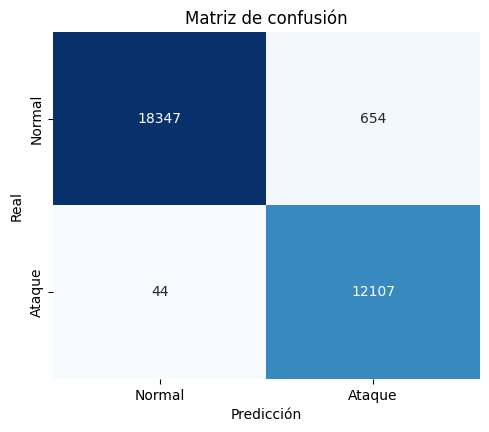

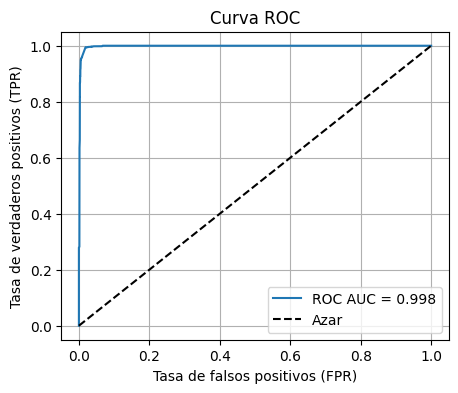

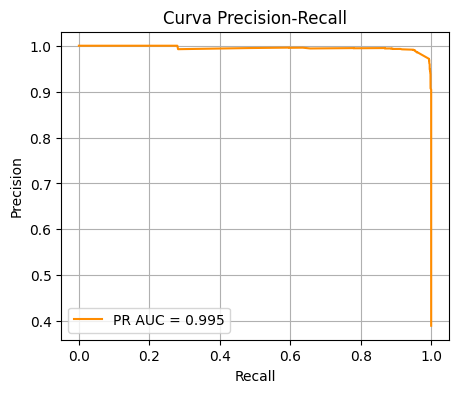


=== 🧾 RESUMEN  ===
✔️ Tasa de detección de ataques (Recall clase 1): 0.279
✔️ Precisión promedio: 0.908
✔️ Total muestras test: 31152


In [ ]:
# ============================================================
# 📊 Visualización de métricas y desempeño del modelo final
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    auc, accuracy_score, f1_score, roc_auc_score, average_precision_score
)

# --- Predicciones y probabilidades ---
y_pred = (best_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_score = best_model.predict_proba(X_test)[:, 1]

# --- Métricas numéricas ---
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_score)
pr_auc = average_precision_score(y_test, y_score)

print("=== 📈 MÉTRICAS DEL MODELO FINAL ===")
print(f"Accuracy:       {acc:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"ROC-AUC:        {roc_auc:.4f}")
print(f"PR-AUC:         {pr_auc:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# --- 1. Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5.5, 4.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Ataque'], yticklabels=['Normal', 'Ataque'])
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# --- 2. Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar')
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 3. Curva Precision-Recall ---
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}', color='darkorange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid(True)
plt.show()

# --- 4. Resumen
print("\n=== 🧾 RESUMEN  ===")
print(f"✔️ Tasa de detección de ataques (Recall clase 1): {recall[-2]:.3f}")
print(f"✔️ Precisión promedio: {precision.mean():.3f}")
print(f"✔️ Total muestras test: {len(y_test)}")
